# Major Projects 20 Questions : Part 1 Classification and Feature Engineering

In [1]:
# Data Source: https://majorprojects.alberta.ca/
# Major Projects are valued at $5 million or greater

## Data Preparation

Import necessary libraries

In [67]:
import pandas as pd
import json
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Create a Pandas DataFrame from a Excel file

In [68]:
data = pd.read_excel('./Major Projects Export.xlsx')
print(data.shape)
data.head()

(703, 14)


,ProjectId,Name,Estimated Cost,Municipality,Schedule,Sector,Type,Stage,Developer,Contractor,Architect,Project Website,Location,Detail
0,7,StoneGate Landing,3.000000e+09,Calgary,2010 - 2021,Mixed-Use,NaN,Under Construction,WAM Development Group / AIMCo,NaN,NaN,www.stonegatelanding.ca/,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",StoneGate Landing is slated to be the largest ...
1,11,Shepard Station Suburban Office Campus Building 1,2.200000e+07,Calgary,2019 - 2020,Commercial,Office: Low-Rise,Under Construction,Shepard Development Corp.,Shepard Development Corporation / CANA / ACE C...,NaN,http://www.shepardstation.com/,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",The Shepard Suburban Office Campus is a 33-acr...
2,22,Barron Building Renovation,1.000000e+08,Calgary,Commencing 2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,NaN,NaN,https://www.strategicgroup.ca/commercial/calga...,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",Conversion of the Barron Building into a 94 un...
3,26,Quarry Crossing II Office Building,7.280000e+07,Calgary,NaN,Commercial,Office: Low-Rise,Proposed,Remington Development Corp.,NaN,NaN,http://www.remingtoncorp.com/leasingLocation.p...,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...","A 512,000 sq ft office building project in Cal..."
4,32,Nolan Hill TownHomes,5.000000e+06,Calgary,NaN,Residential,Townhouses,Proposed,Jayman Modus,NaN,NaN,NaN,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",NaN


Extract from geojson the start location coordinates (Longitude, Latitude)

In [69]:
data['Location'] = data['Location'].apply(json.loads)

Latitude = []
Longitude = []

for i in range(len(data)):
    geo = data['Location'][i]['geometry']
    if geo['type'] == 'Point':
        Longitude.append(geo['coordinates'][0])
        Latitude.append(geo['coordinates'][1])
    elif geo['type'] == 'LineString':
            Longitude.append(geo['coordinates'][0][0])
            Latitude.append(geo['coordinates'][0][1])
    elif geo['geometries'][0]['type'] == 'Point':
            Longitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0])
            Latitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][1])
    elif geo['geometries'][0]['type'] == 'LineString':
            Longitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0][0])
            Latitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0][1])
    else:
        print('New Type Error')
        
data['Start Latitude'] = Latitude
data['Start Longitude'] = Longitude

Drop rows where there is no Estimated Cost and divide cost by a million

In [70]:
data = data.dropna(subset=['Estimated Cost'])
data['Estimated Cost'] = data['Estimated Cost']/(1e6)
data.shape

(695, 16)

Change Schedule Completion, assume 2027 for all proposed Project w/o Schedule

In [71]:
data['Schedule'] = data['Schedule'].str[-4:]
data['Schedule'] = data['Schedule'].fillna(2027)
data['Schedule'] = data['Schedule'].astype(int)

Rename Colums

In [72]:
data.rename(columns={'Name':'Project Name', 'Estimated Cost':'Estimated Cost (millions)', 'Schedule':'Forecasted Completion'}, inplace=True)

Assume that Projects that were under construction before 2020 are complete(unless are Cancelled or On Hold)

In [73]:
data.loc[data['Forecasted Completion']<2020, 'Stage']='Completed'
data['Stage'] = data['Stage'].replace('Under Construction','Started')
data['Stage'].value_counts()

Proposed     321
Started      306
Completed     68
Name: Stage, dtype: int64

Make Type equal to Sector when there is no type (except Infrastructure)

In [74]:
data['Type'] = data['Type'].fillna(data['Sector'])
data['Type'] = data['Type'].replace('Infrastructure','Other')

Drop columns not needed and set ProjectId as index

In [75]:
data.drop(columns=['Contractor','Architect','Project Website', 'Detail', 'Location'], inplace=True)
data.set_index('ProjectId')

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
7,StoneGate Landing,3000.0,Calgary,2021,Mixed-Use,Mixed-Use,Started,WAM Development Group / AIMCo,51.172501,-113.975800
11,Shepard Station Suburban Office Campus Building 1,22.0,Calgary,2020,Commercial,Office: Low-Rise,Started,Shepard Development Corp.,50.931721,-113.970596
22,Barron Building Renovation,100.0,Calgary,2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,51.046070,-114.076614
26,Quarry Crossing II Office Building,72.8,Calgary,2027,Commercial,Office: Low-Rise,Proposed,Remington Development Corp.,50.966900,-114.002899
32,Nolan Hill TownHomes,5.0,Calgary,2027,Residential,Townhouses,Proposed,Jayman Modus,51.162041,-114.160912
...,...,...,...,...,...,...,...,...,...,...
4268,Ben Calf Robe School Replacement,25.6,Edmonton,2021,Institutional,School,Started,Edmonton Catholic School District,53.571312,-113.438348
4269,École A la Decouverte School,17.2,Edmonton,2022,Institutional,School,Started,The Greater North Central Francophone Educatio...,53.641039,-113.503243
4270,Ecole Secondaire Beaumont Composition High Sch...,14.0,Beaumont,2022,Institutional,School,Started,The Black Gold School Division,53.348926,-113.422593


In [76]:
data.isnull().any()

ProjectId                    False
Project Name                 False
Estimated Cost (millions)    False
Municipality                 False
Forecasted Completion        False
Sector                       False
Type                         False
Stage                        False
Developer                    False
Start Latitude               False
Start Longitude              False
dtype: bool

## Data Exploration

### Descriptive Statistics

In [77]:
data.describe(include=[object]).transpose()

,count,unique,top,freq
Project Name,695,695,Sand/salt Storage Building,1
Municipality,695,148,Calgary,181
Sector,695,11,Infrastructure,158
Type,695,56,Roadwork,79
Stage,695,3,Proposed,321
Developer,695,414,City of Edmonton,33


In [78]:
data.describe(exclude=['int64','object']).transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Estimated Cost (millions),695.0,222.06,971.86,5.00,10.10,23.00,73.90,16000.00
Forecasted Completion,695.0,2022.11,3.14,2014.00,2020.00,2021.00,2024.00,2027.00
Start Latitude,695.0,52.51,1.81,49.02,51.04,52.82,53.55,58.48
Start Longitude,695.0,-113.80,1.63,-119.77,-114.08,-113.70,-113.39,-110.01


The Most Expensive Projects are (above $5m):

In [79]:
data[data['Estimated Cost (millions)']>5000]

,ProjectId,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
151,614,Trans Mountain Pipeline Expansion,7400.0,Yellowhead County|Improvement District No. 12 ...,2019,Pipelines,Pipelines,Completed,Government of Canada/Trans Mountain Corporation,53.543042,-113.361502
193,873,"Green Line LRT, Stage 1",5500.0,Calgary,2026,Infrastructure,Transit,Proposed,City of Calgary,50.931484,-113.968971
280,3579,Keystone XL,10000.0,Cypress County|Provost No. 52|Special Area No....,2020,Pipelines,Pipelines,Started,TransCanada Energy Ltd.,52.635032,-111.275432
335,3735,SinoCan Global Upgrader and Petrochemical Faci...,8500.0,Lamont County,2021,Oil and Gas,Upgrader,Proposed,SinoCan Global,53.775939,-112.825255
432,3921,Telus Infrastructure Upgrades (Province wide),16000.0,Edmonton,2024,Industrial,Telecommunication,Started,TELUS,53.540116,-113.491361


Names and Number of unique project types

In [80]:
print(data.Type.unique())
len(data.Type.unique())

['Mixed-Use' 'Office: Low-Rise' 'Apartment: Mid-Rise' 'Townhouses'
 'Distribution Centre' 'Arts and Culture' 'Business Park' 'Roadwork'
 'Transit' 'Office Renovation' 'Research Centre' 'Shopping Plaza'
 'Apartment: High-Rise' 'Telecommunication' 'Water/Wastewater' 'Other'
 'Airport' 'Emergency Services' 'Flood Mitigation' 'Health Care'
 'Administration' 'Post-Secondary' 'Library' 'Continuing Care'
 'Student Residence' 'Religious' 'School' 'Gas' 'Oil Sands: In Situ'
 'Oil Sands: Mining' 'Upgrader' 'Bioproduct' 'Chemical' 'Metals'
 'Military' 'Pipelines' 'Natural Gas' 'Wind' 'Apartment: Low-Rise'
 'Attractions' 'Sports Facility' 'Hotel' 'Park' 'Museum' 'Solar'
 'Event Space' 'Community Centre' 'Agriculture' 'Community' 'Power Centre'
 'Transmission Line' 'Distribution/Storage' 'Big-Box Store'
 'Shopping Mall' 'Auto Dealership' 'Bioenergy']


56

### Bar Chart of Project Types

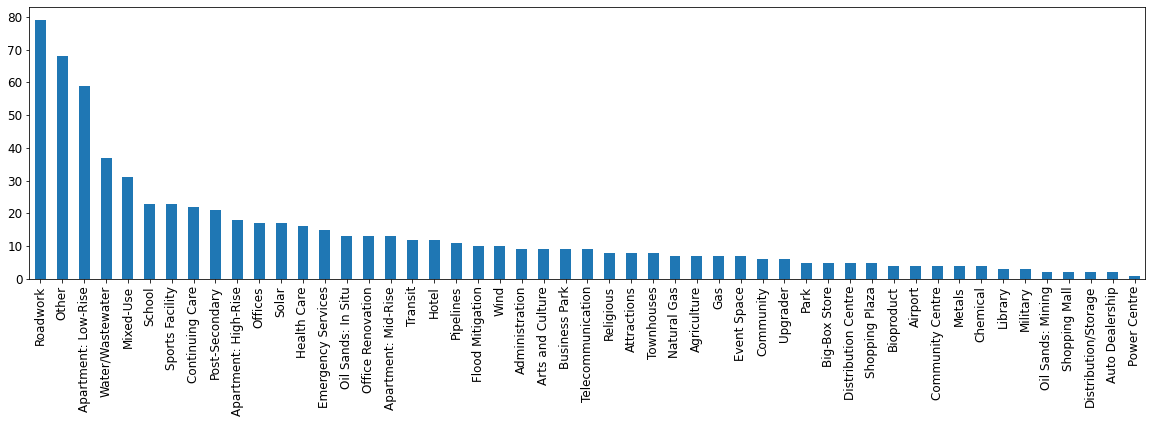

In [97]:
data.Type.value_counts().plot.bar(figsize = [20, 5], fontsize = 12)

The Projects types with only 1 or 2 Projects are:

In [84]:
data.Type.value_counts().to_frame().tail(10).transpose()

,Oil Sands: Mining,Shopping Mall,Distribution/Storage,Auto Dealership,Power Centre,Bioenergy,Student Residence,Transmission Line,Museum,Research Centre
Type,2,2,2,2,1,1,1,1,1,1


### Names and Number of Unique Sectors

In [85]:
print(len(data.Sector.unique()))
data.Sector.value_counts().to_frame().transpose()

11


,Infrastructure,Institutional,Residential,Tourism / Recreation,Commercial,Power,Industrial,Oil and Gas,Mixed-Use,Retail,Pipelines
Sector,158,127,108,77,48,42,42,32,31,19,11


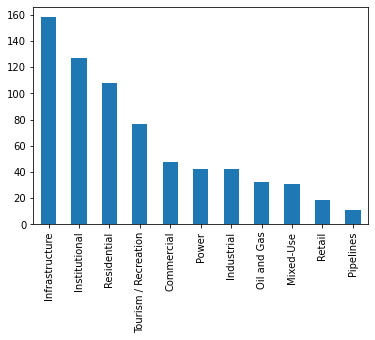

In [86]:
data.Sector.value_counts().plot.bar()

### (Public) Infrastructure Sector

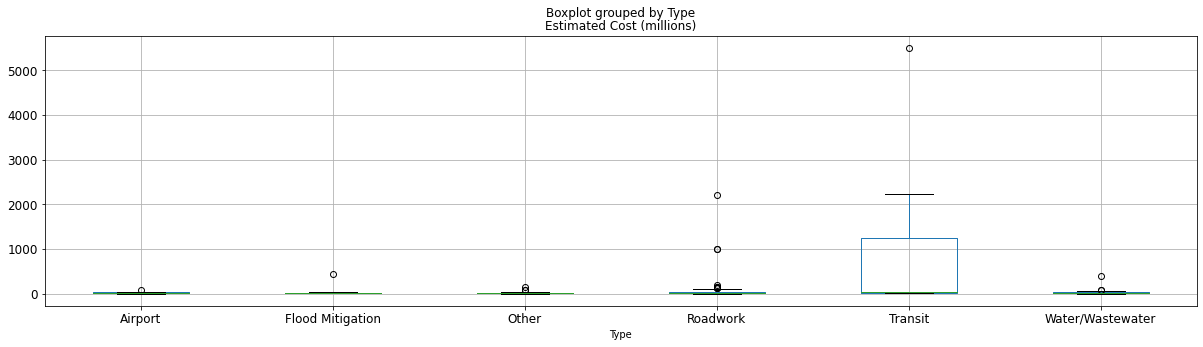

In [87]:
data[data['Sector']=='Infrastructure'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Institutional Sector

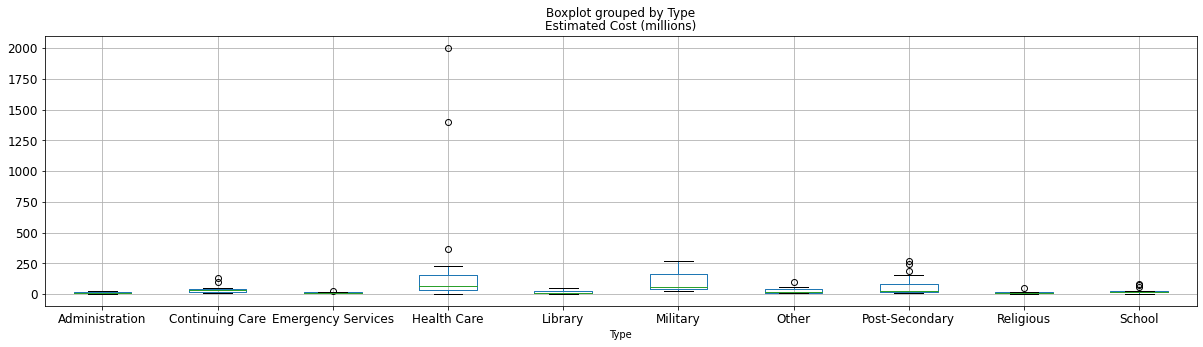

In [88]:
data[data['Sector']=='Institutional'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Residential Sector
Corrections: High-Rise above $200m are Community Type and Student Residence is Other Type

In [89]:
data['Type'] = data['Type'].replace('Student Residence','Other')
data.loc[(data['Sector']=='Residential') & (data['Type']=='Apartment: High-Rise') & (data['Estimated Cost (millions)']>200), 'Type']='Community'

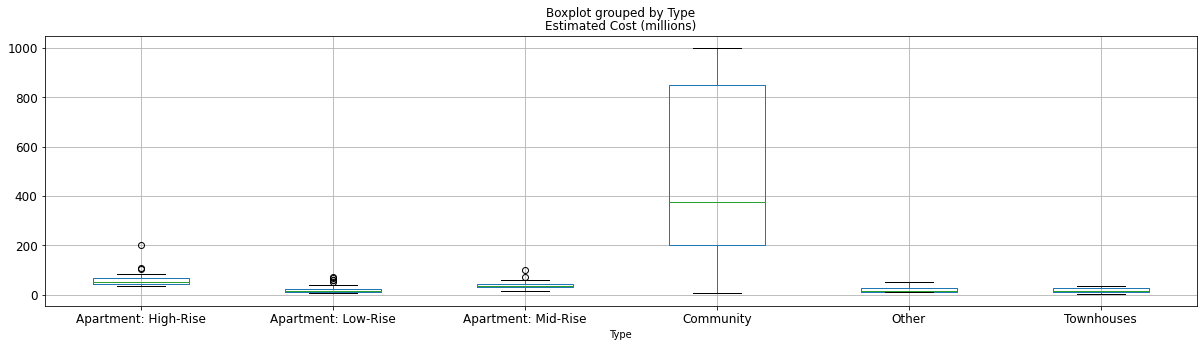

In [90]:
data[data['Sector']=='Residential'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Tourism Sector
Correction: Museum is an Attractions Type and Tourism is the Sector

In [91]:
data['Type'] = data['Type'].replace('Museum','Attractions')
data['Sector'] = data['Sector'].replace('Tourism / Recreation','Tourism')

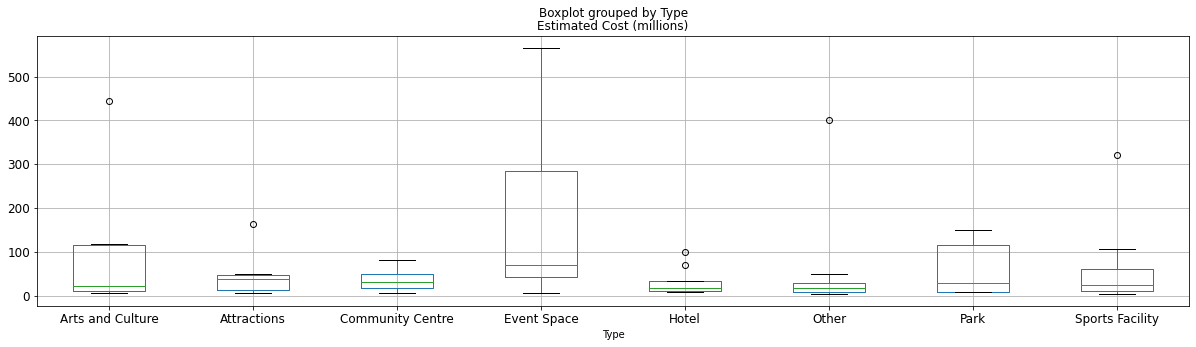

In [93]:
data[data['Sector']=='Tourism'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Commercial Sector
Correction: There is only Office Low-Rise Type, renamed to Offices

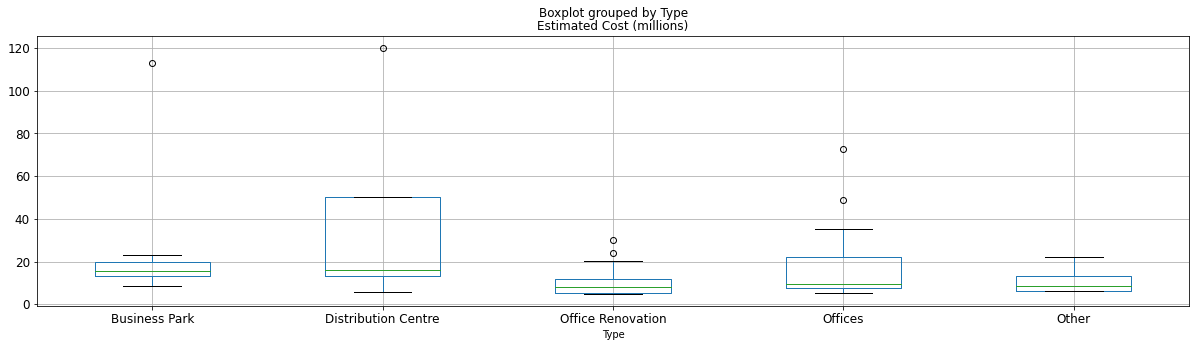

In [94]:
data['Type'] = data['Type'].replace('Office: Low-Rise','Offices')
data[data['Sector']=='Commercial'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Power Sector
Corrections: Bioenergy and Transmisson Line Types renamed to Other

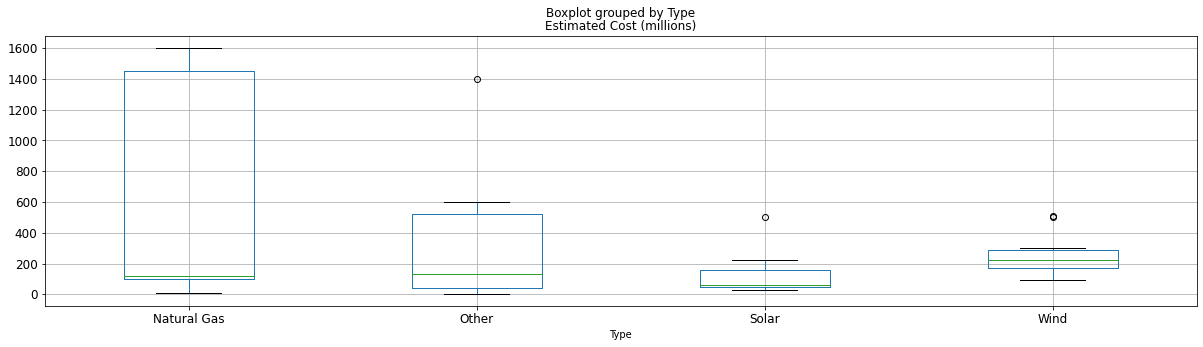

In [95]:
data['Type'] = data['Type'].replace('Bioenergy','Other')
data['Type'] = data['Type'].replace('Transmission Line','Other')
data[data['Sector']=='Power'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Industrial Sector
Correction: Research Centre Type renamed to Other

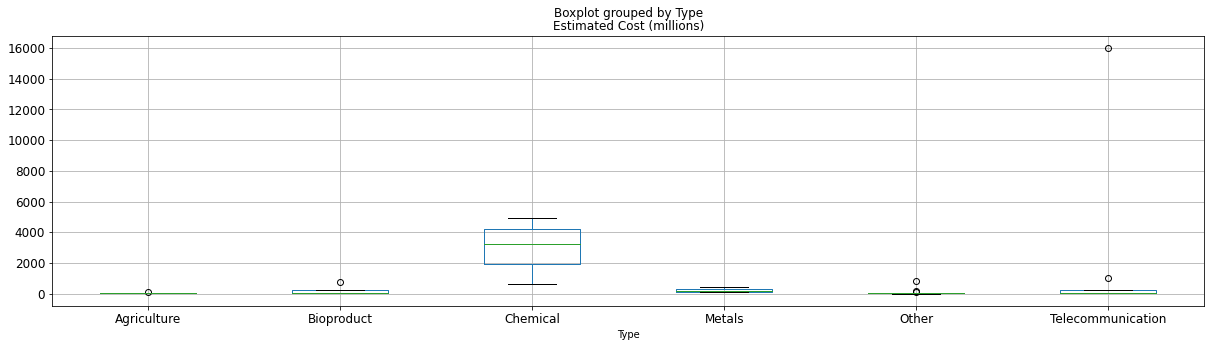

In [96]:
data['Type'] = data['Type'].replace('Research Centre','Other')
data[data['Sector']=='Industrial'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Oil and Gas Sector (Including Pipelines)

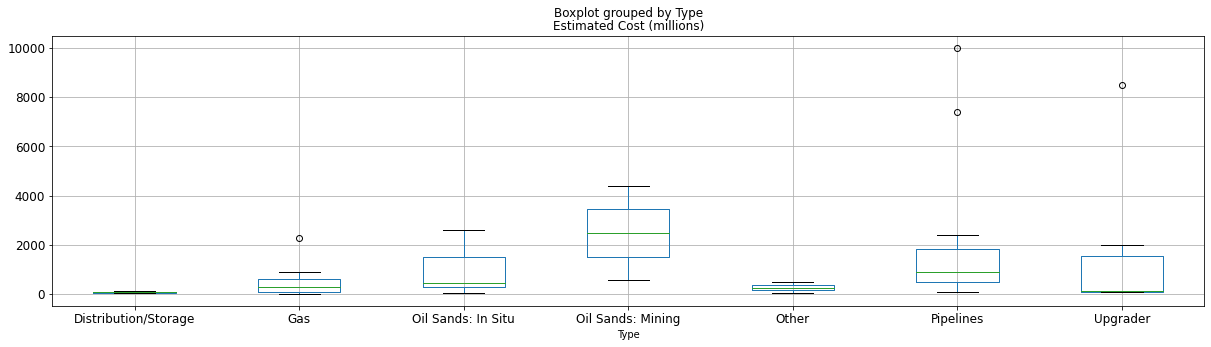

In [99]:
data['Sector'] = data['Sector'].replace('Pipelines','Oil and Gas')
data[data['Sector']=='Oil and Gas'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Retail Sector (Including Mixed-Use)
Correction: Power Centre Type renamed to Mixed-Use

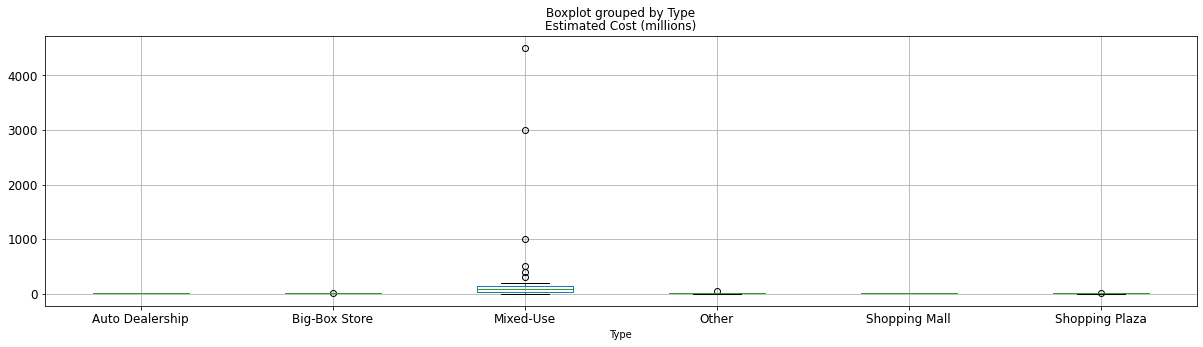

In [100]:
data['Sector'] = data['Sector'].replace('Mixed-Use','Retail')
data['Type'] = data['Type'].replace('Power Centre','Mixed-Use')
data[data['Sector']=='Retail'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Number of Unique Sectors and Types (after corrections)

In [101]:
print('Number of Unique Sectors:',len(data.Sector.unique()))
print('Number of Unique Types:',len(data.Type.unique()))

Number of Unique Sectors: 9
Number of Unique Types: 50


In [103]:
data[['Sector', 'Type', 'ProjectId']].groupby(by=['Sector','Type']).count()

ProjectId
Sector         Type                           
Commercial     Business Park                 9
               Distribution Centre           5
               Office Renovation            13
               Offices                      17
               Other                         4
Industrial     Agriculture                   7
               Bioproduct                    4
               Chemical                      4
               Metals                        4
               Other                        14
               Telecommunication             9
Infrastructure Airport                       4
               Flood Mitigation             10
               Other                        16
               Roadwork                     79
               Transit                      12
               Water/Wastewater             37
Institutional  Administration                9
               Continuing Care              22
               Emergency Services           15
               Health Care                  16
               Library                       3
               Military                      3
               Other                         7
               Post-Secondary               21
               Religious                     8
               School                       23
Oil and Gas    Distribution/Storage          2
               Gas                           7
               Oil Sands: In Situ           13
               Oil Sands: Mining             2
               Other                         2
               Pipelines                    11
               Upgrader                      6
Power          Natural Gas                   7
               Other                         8
               Solar                        17
               Wind                         10
Residential    Apartment: High-Rise         18
               Apartment: Low-Rise          59
               Apartment: Mid-Rise          13
               Community                     6
               Other                         4
               Townhouses                    8
Retail         Auto Dealership               2
               Big-Box Store                 5
               Mixed-Use                    32
               Other                         4
               Shopping Mall                 2
               Shopping Plaza                5
Tourism        Arts and Culture              9
               Attractions                   8
               Community Centre              4
               Event Space                   7
               Hotel                        12
               Other                         9
               Park                          5
               Sports Facility              23